# Step 1: Setting Up the Environment
We are configuring for a natural language processing project using TensorFlow and Keras. It includes:

1. **Core Libraries**: Importing `numpy` and `pandas` for data manipulation.
2. **Text Processing**: Using `pickle` for object serialization, and `nltk` for downloading stopwords to filter out common words.
3. **Neural Network Setup**: Utilizing TensorFlow and Keras to build and train Recurrent Neural Networks (RNNs), with layers like `LSTM` (a type of RNN layer) and `Embedding` designed for sequence-based tasks such as text classification or generation.# 1. Import the Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import string
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional,Attention, Lambda
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as k

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Step 2: Implementing Custom Attention Layer

This code snippet defines a custom Attention Layer using TensorFlow, designed for sequence-based tasks like machine translation. It initializes trainable weights (`W_a`, `U_a`, `V_a`) to compute attention weights and context vectors from encoder and decoder outputs. The `call` method processes inputs through energy and context computation steps:

- **Energy Step**: Calculates attention scores by combining and activating the products of encoder sequences with weights.
- **Context Step**: Computes context vectors by applying these scores to encoder sequences.

The layer outputs these context vectors and scores, critical for models that require understanding the importance of different parts of the input sequence.

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape) 
    def call(self, inputs):

        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)
            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            e_i = K.softmax(e_i)
            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):

            logger.debug("Running attention vector computation step")
            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)
            logger.debug(f"ci.shape = {c_i.shape}")
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)

        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):

        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 3: Loading and Preprocessing Data

Downloaded our CNN/Daily Mail Dataset from Kaggle and have mounted it in our drives. Loading the data from the drive.

In [ ]:
df_train=pd.read_csv('/content/drive/MyDrive/DLProject/cnn_dailymail/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/DLProject/cnn_dailymail/test.csv')
df_val=pd.read_csv('/content/drive/MyDrive/DLProject/cnn_dailymail/validation.csv')


In [ ]:
df_train= df_train[:10000]
df_test= df_test[:10000]
df_val= df_val[:10000]
df_train.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


The dictionary, `contraction_mapping`, maps common English contractions to their expanded forms, aiding in text normalization for natural language processing tasks. For instance, it converts "can't" to "cannot" and "you're" to "you are", ensuring consistency in word forms for better analysis or processing of text data.

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

This `text_cleaner` function is designed for cleaning text data in two possible ways, indicated by the `num` parameter: when `num` is 0, it removes stopwords from the text after cleaning; if not, it retains all words. The function lowers the text case, removes parenthetical text and double quotes, expands contractions using a predefined dictionary, eliminates possessive endings, and filters out non-alphabetic characters. It also discards single-character words to focus on more meaningful content.

In [ ]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]

    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

Below code blocks apply the text_cleaner function to clean and preprocess text data from different data sets: training, testing, and validation.

In [ ]:
cleaned_text = []
cleaned_text_test=[]
cleaned_text_valid=[]

for t in df_train['article']:
    cleaned_text.append(text_cleaner(t,0))

for t in df_test['article']:
    cleaned_text_test.append(text_cleaner(t,0))

for t in df_val['article']:
    cleaned_text_valid.append(text_cleaner(t,0))

In [ ]:
cleaned_summary = []
cleaned_summary_test = []
cleaned_summary_valid = []

for t in df_train['highlights']:
    cleaned_summary.append(text_cleaner(t,1))

for t in df_test['highlights']:
    cleaned_summary_test.append(text_cleaner(t,1))

for t in df_val['highlights']:
    cleaned_summary_valid.append(text_cleaner(t,1))

In [ ]:
df_train['text']=cleaned_text
df_train['summary']=cleaned_summary

df_test['text']=cleaned_text_test
df_test['summary']=cleaned_summary_test

df_val['text']=cleaned_text_valid
df_val['summary']=cleaned_summary_valid

Below Code Blocks have Data Preprocessing steps where we have dropped NA blocks and also added start and finih to our summary

In [ ]:
df_train.replace('', np.nan, inplace=True)
df_train.dropna(axis=0,inplace=True)

df_test.replace('', np.nan, inplace=True)
df_test.dropna(axis=0,inplace=True)

df_val.replace('', np.nan, inplace=True)
df_val.dropna(axis=0,inplace=True)

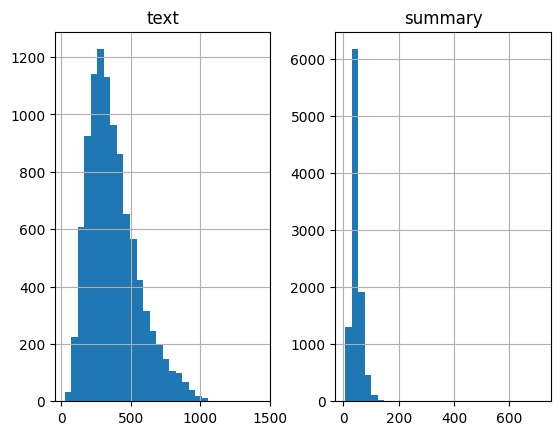

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df_train['text']:
      text_word_count.append(len(i.split()))

for i in df_train['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
max_text_len=300
max_summary_len=100

In [ ]:
df_train['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_test['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_val['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

The below code blocks preprocesses text data for machine learning by converting text to sequences, pruning rare words, and padding sequences to a uniform length for model training. It uses a `Tokenizer` to create and refine a vocabulary based on word frequency, ensuring that the dataset is optimized for relevance and consistency.

In [ ]:
x_train=df_train['text'].to_numpy()
y_train=df_train['summary'].to_numpy()
x_test=df_test['text'].to_numpy()
y_test=df_test['summary'].to_numpy()
x_validate=df_val['text'].to_numpy()
y_validate=df_val['summary'].to_numpy()

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 53.49472950017437
Total Coverage of rare words: 1.949848018235144


In [ ]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_train))

x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)
x_val_seq = x_tokenizer.texts_to_sequences(x_validate)
x_train = pad_sequences(x_train_seq,maxlen=max_text_len,padding='post')
x_test = pad_sequences(x_test_seq,maxlen=max_text_len,padding='post')
x_validate = pad_sequences(x_val_seq,maxlen=max_text_len,padding='post')

In [ ]:
x_vocab = x_tokenizer.num_words +1
x_vocab

41340

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
thresh=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in y_tokenizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value

print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 65.40604208448731
Total Coverage of rare words: 5.9311357576226


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=total_count-count)
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train)
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_validate)
#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_text_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_text_len, padding='post')
y_validate   =   pad_sequences(y_val_seq, maxlen=max_text_len, padding='post')
#size of vocabulary
y_vocab  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_vocab))

Size of vocabulary in Y = 10868


This code filters out training, testing and validaiton examples where the target sequence contains exactly two non-zero entries, storing the indices of such examples in `ind`. It then removes these specific entries from both the `x` and `y` arrays to refine the dataset.

In [ ]:
ind=[]
for i in range(len(y_train)):
    count=0
    for j in y_train[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
x_train=np.delete(x_train,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_test)):
    count=0
    for j in y_test[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_validate)):
    count=0
    for j in y_validate[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_val=np.delete(y_validate,ind, axis=0)
x_val=np.delete(x_validate,ind, axis=0)

In [ ]:
word2id = x_tokenizer.word_index
id2word = x_tokenizer.index_word
vocab_size = x_vocab
emded_size=300
window_size=5

## Produce Batches

 Below function, generate_context_word_pairs, generates context and target word pairs from a given corpus using a specified window size, for use in training word embedding models like Word2Vec. For each word in the corpus, it identifies the surrounding words within the window as the context and uses the current word as the target. The context words are padded to a fixed length for consistent input size, and the target words are one-hot encoded based on the vocabulary size. The function yields these context-target pairs for training, and the accompanying test code iterates through these pairs, printing the first 10 where the context contains no padding (indicated by 0).

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []
            start = index - window_size
            end = index + window_size + 1

            context_words.append([words[i]
                                 for i in range(start, end)
                                 if 0 <= i < sentence_length
                                 and i != index])
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)
            y = tf.keras.utils.to_categorical(label_word, vocab_size)
            yield (x, y)


# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=x_train, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])

        if i == 10:
            break
        i += 1

Context (X): ['associated', 'press', 'published', 'est', 'october', 'est', 'october', 'bishop', 'fargo', 'catholic'] -> Target (Y): updated
Context (X): ['press', 'published', 'est', 'october', 'updated', 'october', 'bishop', 'fargo', 'catholic', 'diocese'] -> Target (Y): est
Context (X): ['published', 'est', 'october', 'updated', 'est', 'bishop', 'fargo', 'catholic', 'diocese', 'north'] -> Target (Y): october
Context (X): ['est', 'october', 'updated', 'est', 'october', 'fargo', 'catholic', 'diocese', 'north', 'dakota'] -> Target (Y): bishop
Context (X): ['october', 'updated', 'est', 'october', 'bishop', 'catholic', 'diocese', 'north', 'dakota', 'exposed'] -> Target (Y): fargo
Context (X): ['updated', 'est', 'october', 'bishop', 'fargo', 'diocese', 'north', 'dakota', 'exposed', 'potentially'] -> Target (Y): catholic
Context (X): ['est', 'october', 'bishop', 'fargo', 'catholic', 'north', 'dakota', 'exposed', 'potentially', 'hundreds'] -> Target (Y): diocese
Context (X): ['october', 'bis

# Step 4: Creating the Word2Vec model

In this step of the notebook, we set up and train a Continuous Bag of Words (CBOW) model using TensorFlow and Keras, optimized to run on a GPU. Key aspects include:

- **Session and Device Configuration**: Begins by clearing any previous TensorFlow sessions and specifies GPU usage to enhance performance.
- **Model Architecture**: Constructs the CBOW model with an Embedding layer for dense word representations, a Lambda layer to average these embeddings, and a Dense layer for predicting the target word using softmax.
- **Model Compilation and Summary**: Compiles the model with categorical crossentropy and RMSprop, and prints a summary to verify the architecture.
- **Weight Utilization**: After training, extracts and reuses the weights from the Embedding layer in a new setup, facilitating the application of learned embeddings to other NLP tasks.

This configuration is essential for efficiently learning word contexts and embeddings that capture semantic relationships in text data.

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional,Attention, Lambda
from tensorflow.keras.models import Model, Sequential,load_model

k.clear_session()
# with strategy.scope():
with tf.device('/gpu:2'):
    cbow = Sequential();
    cbow.add(Embedding(input_dim=vocab_size, output_dim=emded_size, input_length=window_size*2));
    cbow.add(Lambda(lambda x: k.mean(x, axis=1), output_shape=(emded_size,)));
    cbow.add(Dense(vocab_size, activation='softmax'));
    cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop');

# view model summary
print(cbow.summary());

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 300)           12402000  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 dense (Dense)               (None, 41340)             12443340  
                                                                 
Total params: 24845340 (94.78 MB)
Trainable params: 24845340 (94.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
with tf.device('/gpu:2'):
    weights = cbow.get_weights()[0]
    weights = weights[1:]
    weights

In [ ]:
wv_layer = Embedding(vocab_size-1,
                     300,
                     mask_zero=False,
                     weights=[weights],
                     input_length=max_text_len,
                     trainable=True)

# Step 5: Creating RL Model

Creating the architecture of RL model with the latent_dim of 256 and embedding dimensionality of 300 using bi-directional LSTM layers as encoders and decoders as stated in research paper

In [ ]:
k.clear_session()

latent_dim = 256
embedding_dim = 300

with tf.device('/gpu:2'):
    # Encoder
    encoder_inputs = Input(shape=(max_text_len, ),name='Encoder_Inputs')

    # Embedding layer
    enc_emb = wv_layer(encoder_inputs)

    # Encoder LSTM 1
    encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True,
                         return_state=True, dropout=0.2,
                         recurrent_dropout=0.2,name='Encoder_BiLSTM_Layer1'))
    (encoder_output1, forward_state_h1, forward_state_c1,backward_state_h1,backward_state_c1) = encoder_lstm1(enc_emb)
    state_h1=Concatenate()([forward_state_h1,backward_state_h1])
    state_c1=Concatenate()([forward_state_c1,backward_state_c1])

    # Encoder LSTM 2
    encoder_lstm2 = Bidirectional(LSTM(latent_dim, return_sequences=True,
                         return_state=True, dropout=0.2,
                         recurrent_dropout=0.2,name='Encoder_BiLSTM_Layer2'))
    (encoder_outputs, forward_state_h2, forward_state_c2,backward_state_h2,backward_state_c2) = encoder_lstm2(encoder_output1)
    state_h=Concatenate()([forward_state_h2,backward_state_h2])
    state_c=Concatenate()([forward_state_c2,backward_state_c2])

    # Set up the decoder, using encoder_states as the initial state
    decoder_inputs = Input(shape=(None, ),name='Decoder_Inputs')

    # Embedding layer
    dec_emb_layer = Embedding(y_vocab, embedding_dim, trainable=True, name='Decoder_Embedding_Inputs')
    dec_emb = dec_emb_layer(decoder_inputs)

    # Decoder LSTM1
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True,
                        return_state=True, dropout=0.2,
                        recurrent_dropout=0.2,name='Decoder_LSTM_Layer')
    (decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    # Attention Layer
    attn_layer = AttentionLayer(name='Attention_Layer')
    attn_out,attn_states=attn_layer([encoder_outputs,decoder_outputs])

    decoder_concat_input=Concatenate(axis=-1,name='Concat_layer')([decoder_outputs,attn_out])
    # Dense layer
    decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax',name='TimeDistribution_Layer'))
    decoder_outputs = decoder_dense(decoder_concat_input)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs,name='PG_Model')

    model.summary()

Model: "PG_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder_Inputs (InputLayer  [(None, 300)]                0         []                            
 )                                                                                                
                                                                                                  
 embedding_1 (Embedding)     (None, 300, 300)             1240170   ['Encoder_Inputs[0][0]']      
                                                          0                                       
                                                                                                  
 bidirectional (Bidirection  [(None, 300, 512),           1140736   ['embedding_1[0][0]']         
 al)                          (None, 256),                                                 

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.002
    drop = 0.75
    epochs_drop = 1.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

## Adam Optimizer

This line configures a model to use the Adam optimizer with a low learning rate of 0.0001 for finer training control, and specifies `sparse_categorical_crossentropy` as the loss function for handling classification tasks with integer labels; it also sets up a learning rate scheduler to adjust the rate based on the `step_decay` function, enhancing optimization efficiency over training epochs.

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')
lrate = LearningRateScheduler(step_decay,verbose=1)

## Early Stopping

It will stop training the model if the val_loss does not decreases after 4 consecutive epochs

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=4)

checkpoint_filepath = 'RL Model'
checkpoint= tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True)

In [ ]:
with tf.device('/gpu:2'):
    history = model.fit(
        [x_train, y_train[:, :-1]],
        y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
        epochs=20,
        callbacks=[es,checkpoint],
        batch_size=64,
        shuffle=True,
        use_multiprocessing=True,
        workers=-1,
        validation_data=([x_validate, y_validate[:, :-1]],
                         y_validate.reshape(y_validate.shape[0], y_validate.shape[1], 1)[:
                         , 1:]),
        )

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 2.7248
Epoch 1: val_loss improved from inf to 1.27628, saving model to RL Model
157/157 [==============================] - 973s 6s/step - loss: 2.7248 - val_loss: 1.2763
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 1.2183
Epoch 2: val_loss improved from 1.27628 to 1.25725, saving model to RL Model
157/157 [==============================] - 940s 6s/step - loss: 1.2183 - val_loss: 1.2572
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 1.2018
Epoch 3: val_loss improved from 1.25725 to 1.24358, saving model to RL Model
157/157 [==============================] - 934s 6s/step - loss: 1.2018 - val_loss: 1.2436
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 1.1900
Epoch 4: val_loss improved from 1.24358 to 1.23199, saving model to RL Model
157/157 [==============================] - 928s 6s/step - loss: 1.1900 - val_loss: 1.2320
Epoch 5/20
157/157 [========

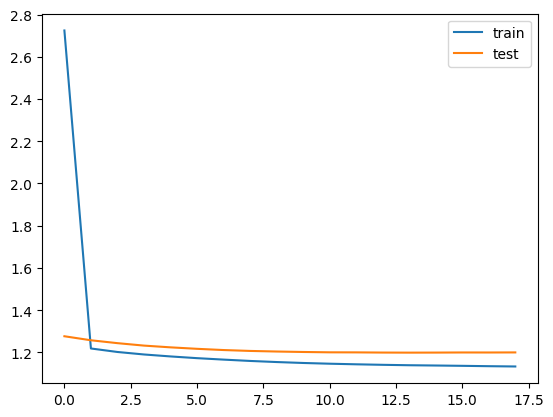

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

## Inference

Set up the inference for the encoder and decoder:

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
!pip install rouge

# 6. Rouge Scores

Calculating the Rouge scores and saving it in CSV file for Graph Plotting and Analysis.

In [ ]:
from rouge import Rouge
ROUGE = Rouge()
Original_summary = list()
Predicted_summary = list()
x_test=x_test[:10]
for i in range(len(x_test)):
    Review = seq2text(x_test[i])
    Original_summary.append(seq2summary(y_test[i]))
    Predicted_summary.append(decode_sequence(x_test[i].reshape(1,max_text_len)))

scores = ROUGE.get_scores(Predicted_summary,Original_summary,avg=True)
print(scores)

1/1 [==============================] - 0s 26ms/step
{'rouge-1': {'r': 0.05448050378401006, 'p': 0.6, 'f': 0.09924692308142043}, 'rouge-2': {'r': 0.0032258064516129032, 'p': 0.016666666666666666, 'f': 0.005405405133674228}, 'rouge-l': {'r': 0.04908188482606907, 'p': 0.5333333333333333, 'f': 0.08935444996314085}}


In [ ]:
df = pd.DataFrame(scores)
print(df)

    rouge-1   rouge-2   rouge-l
r  0.054481  0.003226  0.049082
p  0.600000  0.016667  0.533333
f  0.099247  0.005405  0.089354
